# Introduction to PyTorch

## What is PyTorch?

PyTorch is an open-source machine learning library developed by Facebook's AI Research lab (FAIR) that provides a flexible and intuitive framework for deep learning. It has gained significant popularity in both academic research and industry applications due to its dynamic computational graph, intuitive API, and seamless integration with the Python ecosystem.

### Key Characteristics of PyTorch:

1. **Pythonic Nature**: PyTorch feels natural to Python programmers, making it easier to learn and integrate with existing Python codebases and libraries.

2. **Dynamic Computational Graph**: Unlike static graph frameworks, PyTorch builds graphs on-the-fly (define-by-run), allowing for more flexible model architecture and easier debugging.

3. **Tensor Computation**: At its core, PyTorch provides a tensor data structure similar to NumPy arrays but with the ability to run on GPUs for accelerated computing.

4. **Automatic Differentiation**: PyTorch includes an automatic differentiation engine called "autograd" that enables automatic computation of gradients needed for training neural networks.

5. **Production Ready**: With TorchScript and other deployment tools, PyTorch models can be easily transitioned from research to production environments.

## PyTorch vs. NumPy

If you're already familiar with NumPy from our first recitation, you'll find many similarities with PyTorch:

| Feature | NumPy | PyTorch |
|---------|-------|---------|
| Primary data structure | ndarray | Tensor |
| Device support | CPU only | CPU and GPU |
| Automatic differentiation | No | Yes |
| Broadcasting behavior | Yes | Yes |
| API style | Similar | Similar |

The main difference is that PyTorch tensors can leverage GPU acceleration and automatically track computations for gradient calculation, making them ideal for deep learning.

## What We'll Cover in This Recitation

1. **PyTorch Tensors**: Creating, manipulating, and understanding the fundamental data structure
2. **Automatic Differentiation**: Understanding how PyTorch computes gradients automatically
3. **Building Neural Networks**: Using the nn module to create neural network architectures
4. **Training Models**: The training loop, optimizers, and loss functions
5. **Data Loading**: Using DataLoader and Dataset classes for efficient data handling
6. **Practical Examples**: Hands-on implementations of common deep learning tasks

By the end of this recitation, you'll have a solid understanding of PyTorch's core components and be able to implement basic deep learning models.

Let's get started!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
# Using CUDA means that we are running on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Linear regresion in numpy vs pytorch

### Numpy

In [2]:
class NumpyDataLoader:
    def __init__(self, X, y, batch_size=32, shuffle=True):
        """
        Initialize a simple NumPy-based data loader.

        Parameters:
            X (ndarray): Input data, shape (N, ...)
            y (ndarray): Labels, shape (N,)
            batch_size (int): Number of samples per batch
            shuffle (bool): Whether to shuffle data each epoch
        """
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.current = 0
        self.num_samples = X.shape[0]
        self.indices = np.arange(self.num_samples)

    def __iter__(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
        self.current = 0
        return self

    def __next__(self):
        if self.current >= self.num_samples:
            raise StopIteration
        start = self.current
        end = min(start + self.batch_size, self.num_samples)
        batch_idx = self.indices[start:end]
        self.current = end
        return self.X[batch_idx], self.y[batch_idx]

    def __len__(self):
        return int(np.ceil(self.num_samples / self.batch_size))

In [3]:
# Generate 3D data (same as before)
num_features = 1
num_points = 250
x = np.random.uniform(-1, 1, size=(num_points, num_features))
m = np.random.random(num_features)
b_true = np.random.random(1)
noise = 0.050
y = x @ m + b_true + np.random.normal(0, noise, size=num_points)
print(f"true m: {m}, true b: {b_true}")


true m: [0.87733243], true b: [0.5036784]


Text(0, 0.5, 'y')

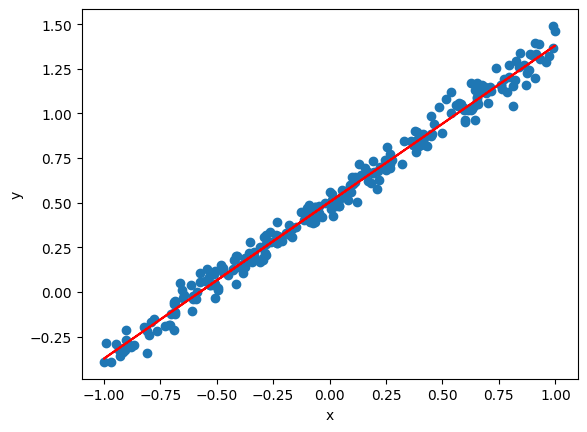

In [4]:
plt.plot(x, y, 'o')
plt.plot(x, x @ m + b_true, color='r')
plt.xlabel('x')
plt.ylabel('y')

In [5]:
data_loader = NumpyDataLoader(x, y, batch_size=8, shuffle=True)
len(data_loader)

32

In [6]:
# Initialize weights
w = np.random.random(num_features) # one for the slope (m) and second for bais (b)
b = np.random.random()

# Hyperparameters
lr = 0.001
epochs = 100

In [7]:
for epoch in range(epochs):
    for x_batch, y_batch in data_loader:
        y_pred = x_batch @ w + b

        # Errors
        error = y_pred - y_batch

        # Gradients (vectorized!)
        # Gradient of the Linear Regression
        grad_w = 2 * np.mean(x_batch.T * error, axis=1)
        grad_b = 2 * np.mean(error)

        # Update parameters
        w -= lr * grad_w
        b -= lr * grad_b

    if epoch % (epochs//10) == 0 or epoch == epochs - 1:
      loss = np.mean((x @ w + b - y) ** 2)
      print(f"Epoch {epoch+1}: Loss = {loss:.5f}")
      # print(w, b)

print()
print(f"bais -> True : {b_true[0]:.3f}, Pred: {b:.3f}")
for i, pair in enumerate(zip(m,w)):
  print(f"w{i} -> True: {pair[0]:.3f}, Pred: {pair[1]:.3f}")



Epoch 1: Loss = 0.21707
Epoch 11: Loss = 0.10496
Epoch 21: Loss = 0.05981
Epoch 31: Loss = 0.03805
Epoch 41: Loss = 0.02574
Epoch 51: Loss = 0.01799
Epoch 61: Loss = 0.01301
Epoch 71: Loss = 0.00967
Epoch 81: Loss = 0.00744
Epoch 91: Loss = 0.00592
Epoch 100: Loss = 0.00496

bais -> True : 0.504, Pred: 0.508
w0 -> True: 0.877, Pred: 0.795


### Pytorch

In [9]:
# Custom Dataset class for PyTorch
# PyTourch expects to get a Dataset object as input, so we inhirt from the Dataset object
class SimpleDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.FloatTensor(x)
        self.y = torch.FloatTensor(y)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)


In [10]:
# Define dimensions
num_features = 1
num_points = 250

# Generate input features using uniform distribution between -1 and 1
x = torch.rand(num_points, num_features) * 2 - 1  # scales [0,1] to [-1,1]
# Generate true weights using random uniform [0,1]
m_true = torch.rand(num_features)

# Define true bias
b_true = torch.rand(1)
noise = .05

# Generate target values using PyTorch operations
y = x @ m_true + b_true + torch.normal(0, noise, size=(num_points,))
# Alternative using @ operator: y = x @ m_true + b_true + torch.normal(0, noise, size=(num_points,))

print(f"true m: {m_true}, true b: {b_true}")


true m: tensor([0.2967]), true b: tensor([0.5927])


Text(0, 0.5, 'y')

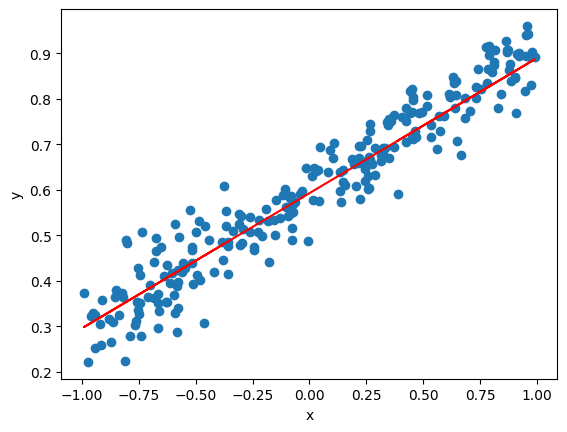

In [11]:
plt.plot(x, y, 'o')
plt.plot(x, x @ m_true + b_true, color='r')
plt.xlabel('x')
plt.ylabel('y')


In [12]:
batch_size = 8
shuffle = True
# Define the dataset based on the generated data in prev cell
dataset = SimpleDataset(x, y)
# PyTourch DataLoder object
data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle)
len(data_loader)
lr = 0.0025
epochs = 100
w = torch.randn(num_features, requires_grad=True)
b = torch.randn(1, requires_grad=True)
print(w)

tensor([0.5809], requires_grad=True)
tensor([0.5809], requires_grad=True)


### Option 1: Manual optimization

In [ ]:
# Option 1: Manual optimization
for epoch in range(epochs):
    for x_batch, y_batch in data_loader:

        # Forward pass
        y_pred = torch.matmul(x_batch, w) + b

        # Compute loss
        loss = torch.mean((y_pred - y_batch) ** 2)

        # Backward pass (compute gradients)
        loss.backward()

        # Update parameters manually
        with torch.no_grad():  # No gradient tracking during updates
            w -= lr * w.grad
            b -= lr * b.grad

            # Reset gradients to zero (important!)
            w.grad.zero_()
            b.grad.zero_()

    if epoch % (epochs//10) == 0 or epoch == epochs - 1:
        # Compute loss on entire dataset
        with torch.no_grad():
            y_pred_all = torch.matmul(torch.FloatTensor(x), w) + b
            loss_all = torch.mean((y_pred_all - torch.FloatTensor(y)) ** 2)
            print(f"Epoch {epoch+1}: Loss = {loss_all:.5f}")

print()
print(f"bias -> True: {b_true[0]:.3f}, Pred: {b.item():.3f}")
for i, (true_val, pred_val) in enumerate(zip(m_true, w.detach().numpy())):
    print(f"w{i} -> True: {true_val:.3f}, Pred: {pred_val:.3f}")

### Option 2: Using PyTorch's built-in optimizers (much simpler!)

In [ ]:
print("\nNow with PyTorch optimizer:\n")

# Reset weights
w = torch.randn(num_features, requires_grad=True)
b = torch.randn(1, requires_grad=True)

# Create optimizer
optimizer = torch.optim.SGD([w, b], lr=lr)

for epoch in range(epochs):
    for x_batch, y_batch in data_loader:
        # Forward pass
        y_pred = torch.matmul(x_batch, w) + b

        # Compute loss
        loss = torch.mean((y_pred - y_batch) ** 2)

        # Zero gradients, backward pass, update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % (epochs//10) == 0 or epoch == epochs - 1:
        # Compute loss on entire dataset
        with torch.no_grad():
            y_pred_all = torch.matmul(torch.FloatTensor(x), w) + b
            loss_all = torch.mean((y_pred_all - torch.FloatTensor(y)) ** 2)
            print(f"Epoch {epoch+1}: Loss = {loss_all:.5f}")

print()
print(f"bias -> True: {b_true[0]:.3f}, Pred: {b.item():.3f}")
for i, (true_val, pred_val) in enumerate(zip(m_true, w.detach().numpy())):
    print(f"w{i} -> True: {true_val:.3f}, Pred: {pred_val:.3f}")


### Option 3: Using nn.Linear for even more PyTorch-like implementation


In [ ]:
print("\nNow with PyTorch nn.Linear module:\n")

# Define model using PyTorch's nn Module
class LinearRegressionModel(torch.nn.Module):
    def __init__(self, input_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(input_dim, 1)  # One output: the prediction

    def forward(self, x):
        return self.linear(x)

# Create model, loss, and optimizer
model = LinearRegressionModel(num_features)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# Training loop
for epoch in range(epochs):
    for x_batch, y_batch in data_loader:
        # Forward pass
        y_pred = model(x_batch).squeeze()

        # Compute loss
        loss = criterion(y_pred, y_batch)

        # Zero gradients, backward pass, update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % (epochs//10) == 0 or epoch == epochs - 1:
        # Compute loss on entire dataset
        with torch.no_grad():
            y_pred_all = model(torch.FloatTensor(x)).squeeze()
            loss_all = criterion(y_pred_all, torch.FloatTensor(y))
            print(f"Epoch {epoch+1}: Loss = {loss_all:.5f}")

# Extract weights and bias for comparison
with torch.no_grad():
    learned_weights = model.linear.weight.data.squeeze().numpy()
    learned_bias = model.linear.bias.item()

print()
print(f"bias -> True: {b_true[0]:.3f}, Pred: {learned_bias:.3f}")
for i, (true_val, pred_val) in enumerate(zip(m_true, [learned_weights])):
    print(f"w{i} -> True: {true_val:.3f}, Pred: {pred_val:.3f}")

## What did we used here....

### PyTorch Tensors



#### What is a Tensor?

A tensor is the fundamental data structure in PyTorch, similar to NumPy's ndarray but with additional capabilities. Tensors are multi-dimensional arrays that can be processed on CPUs or GPUs and are designed to support automatic differentiation.



#### Initialize tensors

In [ ]:
# From lists
tensor_from_list = torch.tensor([1, 2, 3, 4])

# From nested lists (2D tensor)
tensor_2d = torch.tensor([[1, 2], [3, 4]])

# Zeros tensor
zeros = torch.zeros(3, 4)  # 3x4 tensor of zeros

# Ones tensor
ones = torch.ones(2, 3)    # 2x3 tensor of ones

# Random tensor (uniform distribution)
random_uniform = torch.rand(2, 2)   # Values between 0 and 1

# Random tensor (normal distribution)
random_normal = torch.randn(2, 2)   # Mean 0, variance 1

# Create tensor with specific values
like_this = torch.ones_like(tensor_2d)  # Same size as tensor_2d, filled with ones

# Creating a range
range_tensor = torch.arange(0, 10, step=1)  # 0 to 9

numpy_array = np.array([1, 2, 3])
tensor_from_numpy = torch.from_numpy(numpy_array)  # Shares memory with numpy_array

#### Tensor properties

In [ ]:
x = torch.randn(3, 4)

# Shape
print(x.shape)      # torch.Size([3, 4])
print(x.size())     # torch.Size([3, 4])

# Data type
print(x.dtype)      # torch.float32

# Number of dimensions
print(x.dim())      # 2

# Number of elements
print(x.numel())    # 12

# Device where tensor is stored
print(x.device)     # cpu (or cuda:0 if on GPU)
x_gpu = x.to(device)
print(x_gpu.device)     # cpu (or cuda:0 if on GPU)
# Get the underlying data as a Python number, list, or NumPy array
if x.numel() == 1:
    print(x.item())  # For single-element tensors
print(x.tolist())    # Convert to nested Python lists
print(x.numpy())     # Convert to NumPy array (CPU only)

#### Reshaping and Transposing


In [ ]:
# Reshaping and Transposing
x = torch.randn(3, 4)

# Reshape
y = x.reshape(12)          # Flattens to 1D tensor with 12 elements
y = x.reshape(2, 6)        # Reshapes to 2x6 tensor
y = x.view(12)             # view is similar to reshape but shares memory (don't count on it)

# Transpose
z = x.t()                  # Transpose (swaps dimensions)
z = x.permute(1, 0)        # More general version of transpose

### Autograd


#### What is a Computation Graph?

A computation graph is a directed graph that represents a sequence of mathematical operations. In PyTorch, computation graphs are built dynamically as operations are performed on tensors, enabling automatic differentiation.

[MiniGrad by Andrej Karpathy](https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLXYLzZ3XzIbi4lL43O6fIU_ojuZwBO6vi)

#### Dynamic vs. Static Graphs

PyTorch uses a **dynamic computation graph** approach:

- **Dynamic Graph (PyTorch)**: Built on-the-fly during forward pass; can be different each time code is run
- **Static Graph (TensorFlow 1.x)**: Built once, then executed repeatedly

The dynamic approach allows for:
- More intuitive debugging
- Use of standard Python control flow (if/else, loops)
- Easier handling of variable-length inputs
- More natural integration with Python code


#### Autograd: Automatic Differentiation

PyTorch's autograd package provides automatic differentiation for operations on tensors. It records operations as they happen, building a computation graph, and then automatically computes gradients.


#### How Autograd Works

1. Create tensors with `requires_grad=True`
2. Perform operations on these tensors
3. Call `.backward()` on the output
4. Access gradients via the `.grad` attribute on input tensors

In [ ]:
x = torch.tensor([2.0], requires_grad=True)
x

In [ ]:
# Example: Simple autograd usage
y = 3 * x**2
y.backward()
print(x.grad)  # Output: tensor([12.])  (derivative of 3x² is 6x, and x=2, so 6*2=12)

In [ ]:
x = torch.tensor([1.0], requires_grad=True)
s = nn.Sigmoid()
a = s(x)
a.backward()
print(f"a: {a}")
print(f"derivative: {a.item() * (1 - a.item())}")
print(f"x.grad: {x.grad}")

### DataLoader

#### The Data Loading Pipeline

Efficiently loading data is crucial for training deep learning models. PyTorch provides a powerful and flexible data loading mechanism through two main components:

1. **Dataset**: Represents a collection of data samples
2. **DataLoader**: Wraps a Dataset and provides batching, shuffling, and parallel data loading

This pipeline allows you to:
- Handle large datasets that don't fit in memory
- Process data on-the-fly during training
- Load data efficiently with multiple CPU workers
- Easily implement custom data augmentation

#### Built-in Datasets

PyTorch provides many pre-implemented datasets in `torchvision`, `torchaudio`, and `torchtext`:


In [ ]:
from torchvision import datasets

# Load MNIST dataset
mnist_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
)


#### Dataset Types

PyTorch supports different types of datasets:

##### **Map-style Datasets**
- Implements `__getitem__()` and `__len__()`
- Supports random access using indices
- Example: Image datasets, tabular data

##### **Iterable-style Datasets**
- Inherits from `IterableDataset`
- Implements `__iter__()` instead of `__getitem__()`
- Used for data streams that can't be randomly accessed
- Example: Data read from database, streaming data


#### The DataLoader Class

The `DataLoader` combines a dataset with features for efficient training:

**Key Parameters**

##### `batch_size`
- Number of samples in each batch
- Higher values use more memory but can increase training speed
- Typically powers of 2 (16, 32, 64, 128, etc.)

##### `shuffle`
- When `True`, shuffles data at the start of each epoch
- Important for stochastic gradient descent
- Set to `False` for evaluation or when order matters

##### `num_workers`
- Number of subprocesses for data loading
- `0` means data loading in the main process
- Increase to speed up data loading (typically 4-8 for single machine)

##### `drop_last`
- When `True`, drops the last incomplete batch
- Useful when batch normalization is used to ensure all batches have the same size

##### `pin_memory`
- When `True`, tensors are copied to pinned (page-locked) memory
- Makes CPU to GPU transfers faster
- Recommended when using GPU

##### `collate_fn`
- Function to merge a list of samples into a mini-batch
- Customize for special handling (e.g., variable-length sequences)
```python
def my_collate_fn(batch):
    # Custom processing for each batch
    data = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    # Do custom processing
    return torch.stack(data), torch.stack(targets)

  dataloader = DataLoader(dataset, batch_size=32, collate_fn=my_collate_fn)
```

In [ ]:
dataloader = DataLoader(
    dataset,               # Your dataset
    batch_size=32,         # Number of samples per batch
    shuffle=True,          # Shuffle data at each epoch
    num_workers=4,         # Number of subprocesses for data loading
    drop_last=False,       # Drop the last incomplete batch
    pin_memory=True        # Pin memory for faster GPU transfer
)
for x_batch, y_batch in dataloader:
    print(x_batch.shape, y_batch.shape)
    break


#### Basic Training Loop:



In [ ]:
# Iterate through batches
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(dataloader):
        # Move to GPU if available
        data, targets = data.to(device), targets.to(device)

        # Forward pass
        outputs = model(data)

        # Compute loss
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.4f}')

### Troch.nn

#### Introduction to torch.nn

The `torch.nn` module is the cornerstone of building neural networks in PyTorch. It provides the building blocks for creating everything from simple linear models to complex deep neural networks. Unlike direct tensor operations, `torch.nn` offers higher-level abstractions that handle parameter management, forward propagation, and integration with optimizers.

#### Core Components of torch.nn

##### 1. nn.Module: The Foundation of All Models

`nn.Module` is the base class for all neural network modules in PyTorch. Every model you create should inherit from this class.


In [ ]:
import torch
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        # Define layers here

    def forward(self, x):
        # Define forward pass
        return output

Key features of `nn.Module`:

- **Automatic Parameter Tracking**: All parameters (defined using `nn.Parameter` or added as submodules) are automatically tracked
- **Nested Structure**: Can contain other modules for hierarchical organization
- **Mode Switching**: Provides `train()` and `eval()` methods to switch between training and evaluation modes
- **Device Movement**: Use `.to(device)` to move all parameters to CPU/GPU

Example of a simple model:

In [ ]:
class SimpleNetwork(nn.Module):
    def __init__(self, input_size=10, hidden_size=10, output_size=10):
        super(SimpleNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.activation = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, output_size)

          # Register them with names
        self.register_module('layer1', self.layer1)
        self.register_module('layer2', self.layer2)

    def forward(self, x):
        x = self.layer1(x)
        x = self.activation(x)
        x = self.layer2(x)
        return x

model = SimpleNetwork()
for name, param in model.named_parameters():
    print(name, param.shape)


##### 2. nn.Parameter: Trainable Parameters

`nn.Parameter` is a special kind of Tensor that is automatically registered as a parameter when assigned as an attribute of an `nn.Module`.

In [ ]:
class CustomLayer(nn.Module):
    def __init__(self, input_size=10):
        super(CustomLayer, self).__init__()
        # This will be automatically registered as a parameter
        self.weights = nn.Parameter(torch.randn(input_size, input_size))
        # This regular tensor will NOT be registered as a parameter
        self.non_param = torch.randn(input_size, input_size)

    def forward(self, x):
        return x @ self.weights

model = CustomLayer()
for name, param in model.named_parameters():
    print(name, param.shape)


##### 3. Common Layer Types

###### Linear Layers

In [ ]:
# Basic linear (fully connected) layer
linear = nn.Linear(in_features=10, out_features=5, bias=True)

# Input: [batch_size, 10]
# Output: [batch_size, 5]

###### Convolutional Layers




In [ ]:
# 2D Convolution
conv2d = nn.Conv2d(
    in_channels=3,      # Input channels (e.g., RGB)
    out_channels=16,    # Output feature maps
    kernel_size=3,      # Filter size
    stride=1,           # Step size
    padding=1,          # Zero-padding
    bias=True           # Whether to include bias
)
# Input: [batch_size, 3, height, width]
# Output: [batch_size, 16, height, width] (with padding=1)

###### Pooling Layers

In [ ]:
# Max pooling
maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

# Average pooling
avgpool = nn.AvgPool2d(kernel_size=2, stride=2)

# Both reduce spatial dimensions by half

###### Normalization Layers


In [ ]:
# Batch Normalization
batchnorm = nn.BatchNorm2d(num_features=16)  # For 2D data (images)

# Layer Normalization
layernorm = nn.LayerNorm(normalized_shape=[16, 32, 32])  # Normalize over last 3 dims

###### Dropout Layers


In [ ]:
# Dropout - randomly zero out elements (regularization technique)
dropout = nn.Dropout(p=0.5)  # 50% probability of zeroing
dropout = nn.Dropout2d(p=0.5)  # 50% probability of zeroing

###### Activation Functions

In [ ]:
# Common activation functions
relu = nn.ReLU()
leaky_relu = nn.LeakyReLU(negative_slope=0.01)
sigmoid = nn.Sigmoid()
tanh = nn.Tanh()
softmax = nn.Softmax(dim=1)  # Apply softmax along dim 1



##### 4. Containers


In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(10, 20)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(20, 15)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(15, 5)

    def forward(self, x):
        x = self.relu1(self.layer1(x))
        x = self.relu2(self.layer2(x))
        x = self.layer3(x)
        return x


class DynamicModel(nn.Module):
    def __init__(self, ):
        super(DynamicModel, self).__init__()
        self.layers = nn.ModuleDict({
            'layer1': nn.Linear(10, 20),
            'relu1': nn.ReLU(),
            'layer2': nn.Linear(20, 15),
            'relu2': nn.ReLU(),
            'layer3': nn.Linear(15, 5)
        })

    def forward(self, x):
        for layer_name in self.layers:
            x = self.layers[layer_name](x)
        return x


# Equivalent to:
model1 = nn.Sequential(
    nn.Linear(10, 20),
    nn.ReLU(),
    nn.Linear(20, 15),
    nn.ReLU(),
    nn.Linear(15, 5)
)

model2  = Model()
model3 = DynamicModel()

x = torch.randn(1, 10)
print(model1(x).shape)
print(model2(x).shape)
print(model3(x).shape)


##### 5. Loss Functions (nn.functional)

PyTorch provides various loss functions in `torch.nn.functional` (often imported as F):

```python
import torch.nn.functional as F

# Cross Entropy Loss (for classification)
loss = F.cross_entropy(predictions, targets)

# Mean Squared Error (for regression)
loss = F.mse_loss(predictions, targets)

# Binary Cross Entropy (for binary classification)
loss = F.binary_cross_entropy(predictions, targets)

# L1 Loss (Mean Absolute Error)
loss = F.l1_loss(predictions, targets)
```

These are also available as modules:

```python
# As modules (stateful)
criterion = nn.CrossEntropyLoss()
loss = criterion(predictions, targets)
```



#### Saving and Loading Models

```python
# Save the entire model
torch.save(model, 'model.pth')

# Save just the state dict (recommended)
torch.save(model.state_dict(), 'model_state_dict.pth')

# Load entire model
loaded_model = torch.load('model.pth')

# Load state dict into an instance
model = SimpleNetwork(input_size, hidden_size, output_size)
model.load_state_dict(torch.load('model_state_dict.pth'))
model.eval()  # Set to evaluation mode
```

###  Building a Simple Classifier in PyTorch

## Exercise: Logistic Regression Classifier

In this exercise, we'll build a complete logistic regression classifier in PyTorch, combining all the concepts we've learned so far.


### 1. Generating Two-Class Blob Data

In [ ]:
from sklearn.datasets import make_blobs

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
n_features = 2
# Generate synthetic data: two blobs for binary classification
X_np, y_np = make_blobs(n_samples=1000, centers=2, n_features=n_features, random_state=42)

# Convert to PyTorch tensors
X = torch.FloatTensor(X_np)
y = torch.FloatTensor(y_np)

# Visualize the data
plt.figure(figsize=(8, 6))
plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np, cmap='coolwarm', alpha=0.7)
plt.title('Binary Classification Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar()
plt.show()

# Print shapes
print(f"X shape: {X.shape}")  # [1000, 2]
print(f"y shape: {y.shape}")  # [1000]


### 2. Creating a Custom Dataset and DataLoader

Now, let's organize our data using PyTorch's Dataset and DataLoader:

In [ ]:
# your code here....

In [ ]:
class BlobDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create train/test split (80/20)
train_size = int(0.8 * len(X))
test_size = len(X) - train_size

# Random split
indices = torch.randperm(len(X))
train_indices = indices[:train_size]
test_indices = indices[train_size:]

# Create datasets
train_dataset = BlobDataset(X[train_indices], y[train_indices])
test_dataset = BlobDataset(X[test_indices], y[test_indices])

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verify the dataloaders
for features, labels in train_loader:
    print(f"Batch features shape: {features.shape}")
    print(f"Batch labels shape: {labels.shape}")
    break


### 3. Building the Logistic Regression Model

Now, let's define our logistic regression model using `torch.nn`:

In [ ]:
# your code here....

In [ ]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        # Linear layer followed by sigmoid for binary classification
        self.linear = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        outputs = self.linear(x)
        outputs = self.sigmoid(outputs)
        return outputs.squeeze()  # Remove extra dimension

# Initialize the model
model = LogisticRegression(n_features)
print(model)

# Examine model parameters
for name, param in model.named_parameters():
    print(f"Parameter {name}: {param.shape}")

### 4. Setting up Loss Function and Optimizer

For binary classification with logistic regression, we'll use Binary Cross Entropy loss

In [ ]:
# your code here....

In [ ]:
# Binary Cross Entropy Loss
criterion = nn.BCELoss()  # Binary Cross Entropy

# Adam optimizer
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### 5. Training Loop

Now let's train the model:

In [ ]:
# your code here....

In [ ]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=100):
    # Training statistics
    train_losses = []

    # Set model to training mode
    model.train()

    # Training loop
    for epoch in range(num_epochs):
        running_loss = 0.0

        # Iterate over batches
        for features, labels in train_loader:
            # Forward pass
            outputs = model(features)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Calculate average loss for the epoch
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        # Print statistics every 10 epochs
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    return train_losses

# Train the model
num_epochs = 100
train_losses = train_model(model, train_loader, criterion, optimizer, num_epochs)

# Plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, marker='o', linestyle='-', markersize=3)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

### 6. Evaluation and Visualization

Let's evaluate our model's performance and visualize the decision boundary:


In [ ]:
# your code here....

In [ ]:
# Evaluation function
def evaluate_model(model, test_loader, criterion):
    model.eval()  # Set model to evaluation mode

    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # No gradients needed
        for features, labels in test_loader:
            # Forward pass
            outputs = model(features)

            # Calculate loss
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Calculate accuracy
            predicted = (outputs > 0.5).float()  # Convert to 0 or 1 based on threshold
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate average loss and accuracy
    avg_loss = test_loss / len(test_loader)
    accuracy = correct / total

    return avg_loss, accuracy

# Evaluate the model
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

# Visualize the decision boundary
def plot_decision_boundary(model, X, y):
    # Set min and max values with some margin
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    # Create a mesh grid
    h = 0.02  # Step size
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Flatten the grid points
    grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

    # Make predictions for the grid points
    model.eval()
    with torch.no_grad():
        Z = model(grid_tensor)
        Z = (Z > 0.5).float()

    # Reshape the predictions
    Z = Z.numpy().reshape(xx.shape)

    # Plot the contour and training points
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolors='k', alpha=0.8)
    plt.title('Decision Boundary of Logistic Regression')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

# Plot the decision boundary
plot_decision_boundary(model, X_np, y_np)

### 7. Making Predictions on New Data

Finally, let's see how to use our trained model for predictions:



In [ ]:
# your code here....

In [ ]:
def predict_sample(model, features):
    # Ensure features are a tensor
    if not isinstance(features, torch.Tensor):
        features = torch.FloatTensor(features)

    # Reshape if it's a single sample
    if features.dim() == 1:
        features = features.unsqueeze(0)

    # Make prediction
    model.eval()
    with torch.no_grad():
        prediction = model(features)
        class_prediction = (prediction > 0.5).float()

    return prediction.item(), class_prediction.item()

# Create a new sample for prediction
new_sample = torch.tensor([3.0, 2.0])
probability, predicted_class = predict_sample(model, new_sample)

print(f"New sample: {new_sample}")
print(f"Probability of class 1: {probability:.4f}")
print(f"Predicted class: {int(predicted_class)}")

### n-dimensional Classifier

## Dense layer

In [ ]:
from torchvision.transforms import ToTensor
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

In [ ]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
def collate_fn_to_device(batch, device):
    """Custom collate function that sends data to specified device"""
    data = torch.stack([item[0] for item in batch]).view(-1, n_features)
    targets = torch.tensor([item[1] for item in batch])
    return data.to(device), targets.to(device)

In [ ]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True, collate_fn=lambda batch: collate_fn_to_device(batch, device))
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True, collate_fn=lambda batch: collate_fn_to_device(batch, device))

In [ ]:
# you code: define a neural nework for calssification 10 lables

In [ ]:
class MultiClassClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, n_hidden=128):
        """
        Multi-class classifier using softmax

        Args:
            input_dim: Number of input features
            num_classes: Number of classes to predict
        """
        super(MultiClassClassifier, self).__init__()

        # Linear layer that maps from input_dim -> num_classes
        self.linear = nn.Sequential(
            nn.Linear(input_dim, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, num_classes)

        )

        # Note: We don't include softmax here because CrossEntropyLoss
        # applies softmax internally for numerical stability

    def forward(self, x):
        """
        Forward pass of the model

        Args:
            x: Input tensor of shape [batch_size, input_dim]

        Returns:
            Logits of shape [batch_size, num_classes]
        """
        # Apply linear layer to get logits
        logits = self.linear(x)
        return logits

    def predict_proba(self, x):
        """
        Get probability predictions

        Args:
            x: Input tensor

        Returns:
            Probabilities after softmax
        """
        with torch.no_grad():
            logits = self.forward(x)
            probs = torch.softmax(logits, dim=1)
        return probs

In [ ]:
# TODO: initilize (model, optimizer, criterion)

In [ ]:
n_features = training_data[0][0].numel() # 28*28=784
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = MultiClassClassifier(n_features, 10).to(device)
print(model)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


In [ ]:
# TODO: write trainilin loop

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
  losses = []
  for x_batch, y_batch in train_dataloader:
    optimizer.zero_grad()                       # discard all previous gradients in the computation graph
    x = x_batch # flatten and move to device if GPU available
    logits = model(x)                           # forward pass (predict)
    loss = criterion(logits, y_batch)           # CrossEntropyLoss executes the softmax transformation internally
    loss.backward()                             # compute gradients for each parameter in the network
    optimizer.step()                            # apply one batch update to the network parameters using the computed gradients
    losses.append(loss.item())
  if (epoch % (num_epochs//10)) == 0:
    print(f"Epoch {epoch}, average loss: {np.mean(losses):.3f}")



In [ ]:
losses = []                                # Will store loss value for each batch
success = []                               # Will store individual prediction results (1 for correct, 0 for incorrect)

# Iterate through batches in the test dataloader
for x_batch, y_batch in test_dataloader:

  logits = model(x_batch.view(-1, n_features).to(device))  # Forward pass: reshape input if needed and move to device (GPU/CPU)
  pred_y = torch.argmax(logits, dim=1)                     # Get predicted class by finding index of maximum value along dimension 1
  # Calculate loss value for this batch
  loss = criterion(logits, y_batch)
  losses.append(loss.item())
  success.extend((pred_y == y_batch).float().tolist())    # Compare predictions with true labels and convert to float (1.0 for correct, 0.0 for incorrect)
print(f"Test loss: {np.mean(losses):.3f}, Success Rate: {sum(success)/len(success):.3f}")